In [2]:
import os
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, \
                            homogeneity_completeness_v_measure
from sklearn.metrics.cluster import contingency_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
import scanpy as sc
import stlearn as st
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/lytq/Spatial-Transcriptomics-Benchmark/utils')
from sdmbench import compute_ARI, compute_NMI, compute_CHAOS, compute_PAS, compute_ASW, compute_HOM, compute_COM

import time
import psutil
import tracemalloc


RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xe. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

/home/lytq/.conda/envs/stlearn/lib/python3.9/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [3]:
BASE_PATH = Path('/home/lytq/Spatial-Transcriptomics-Benchmark/data/BRCA1')
sample = 'V1_Human_Breast_Cancer_Block_A_Section_1'

def evaluate_clustering(adata: sc.AnnData, df_meta, time_taken: float, memory_used: float, output_dir: str) -> dict:
    """Evaluate clustering using sdmbench"""
    gt_key = 'ground_truth'
    pred_key = 'X_pca_kmeans'
    adata.obs['ground_truth'] = df_meta['ground_truth_le'].values
    adata = adata[~pd.isnull(adata.obs['ground_truth'])]
    
    results = {
        "ARI": compute_ARI(adata, gt_key, pred_key),
        "AMI": compute_NMI(adata, gt_key, pred_key),
        "Homogeneity": compute_HOM(adata, gt_key, pred_key),
        "Completeness": compute_COM(adata, gt_key, pred_key),
        "ASW": compute_ASW(adata, pred_key),
        "CHAOS": compute_CHAOS(adata, pred_key),
        "PAS": compute_PAS(adata, pred_key),
        "Time": time_taken,
        "Memory": memory_used
    }
    
    df_results = pd.DataFrame([results])
    df_results.to_csv(os.path.join(output_dir, "metrics.csv"), index=False)
    return results

In [4]:
OUTPUT_PATH = Path(f"/home/lytq/Spatial-Transcriptomics-Benchmark/RESULTS/BRCA1/stLearn/")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
TILE_PATH = Path(f'{OUTPUT_PATH}/tiles/')
TILE_PATH.mkdir(parents=True, exist_ok=True)

In [6]:
# Load data
data = st.Read10X(os.path.join(BASE_PATH, sample))
ground_truth_df = pd.read_csv( BASE_PATH / sample / 'metadata.tsv', sep='\t')
ground_truth_df['ground_truth'] = ground_truth_df['fine_annot_type']

/home/lytq/.conda/envs/stlearn/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/lytq/.conda/envs/stlearn/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
data

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [10]:
# Start time and memory usage tracking
start_time = time.time()
tracemalloc.start()

# Load data
data = st.Read10X(os.path.join(BASE_PATH, sample))
ground_truth_df = pd.read_csv( BASE_PATH / sample / 'metadata.tsv', sep='\t')
ground_truth_df['ground_truth'] = ground_truth_df['fine_annot_type']

# Pre-processing for ground truth
le = LabelEncoder()
ground_truth_le = le.fit_transform(list(ground_truth_df["ground_truth"].values))
n_cluster = 20
data.obs['ground_truth'] = ground_truth_df["ground_truth"]
ground_truth_df["ground_truth_le"] = ground_truth_le 

# pre-processing for gene count table
st.pp.filter_genes(data,min_cells=1)
st.pp.normalize_total(data)
st.pp.log1p(data)
st.em.run_pca(data,n_comps=15)
st.pp.tiling(data, TILE_PATH)
st.pp.extract_feature(data)

# stSME
st.spatial.SME.SME_normalize(data, use_data="raw", weights="physical_distance")
data_ = data.copy()
data_.X = data_.obsm['raw_SME_normalized']
st.pp.scale(data_)
st.em.run_pca(data_,n_comps=30)
st.tl.clustering.kmeans(data_, n_clusters=n_cluster, use_data="X_pca", key_added="X_pca_kmeans")

st.pp.neighbors(data_, n_neighbors=10, use_rep="X_pca")
st.em.run_umap(data_)


# End time and memory usage tracking
end_time = time.time()
time_taken = end_time - start_time
memory_used = tracemalloc.get_traced_memory()[1] / (1024 ** 2) # in MB
tracemalloc.stop()

os.system(f"rm -rf {TILE_PATH}")

metrics = evaluate_clustering(data_, ground_truth_df, time_taken, memory_used, OUTPUT_PATH)


/home/lytq/.conda/envs/stlearn/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/lytq/.conda/envs/stlearn/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Normalization step is finished in adata.X
Log transformation step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature: 100%|██████████ [ time left: 00:00 ]  


The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by SME is added to adata.obsm['raw_SME_normalized']
Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans cluster ...


/home/lytq/.conda/envs/stlearn/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Kmeans cluster is done! The labels are stored in adata.obs["kmeans"]
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
UMAP is done! Generated in adata.obsm['X_umap'] nad adata.uns['umap']


In [11]:
n_cluster

20

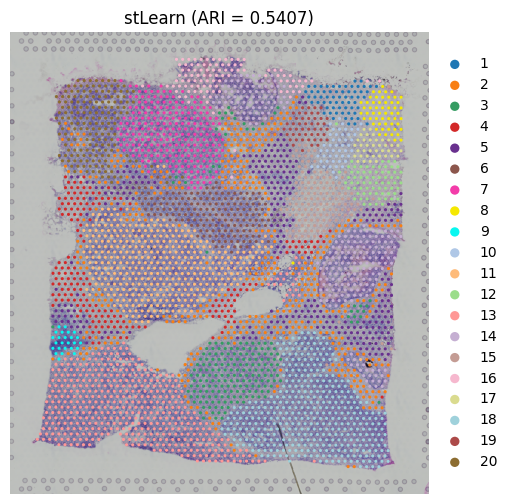

In [13]:
# Plot clusters
fig, ax = plt.subplots(figsize=(6, 6))
st.pl.cluster_plot(data_, use_label="X_pca_kmeans", ax=ax)
handles, labels = ax.get_legend_handles_labels()
new_labels = [str(int(label) + 1) if label.isdigit() else label for label in labels]
ax.legend(handles, new_labels, loc='center left', frameon=False, bbox_to_anchor=(1, 0.5), markerscale=3)
plt.title(f"stLearn (ARI = {metrics['ARI']:.4f})")
plt.savefig(OUTPUT_PATH / 'clustering.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [14]:
data_

AnnData object with n_obs × n_vars = 3798 × 24923
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'ground_truth', 'tile_path', 'X_pca_kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'gene_expression_correlation', 'physical_distance', 'morphological_distance', 'weights_matrix_all', 'weights_matrix_pd_gd', 'weights_matrix_pd_md', 'weights_matrix_gd_md', 'neighbors', 'umap', 'X_pca_kmeans_colors'
    obsm: 'spatial', 'X_pca', 'X_tile_feature', 'X_morphology', 'imputed_data', 'top_weights', 'raw_SME_normalized', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [15]:
data_.obs.to_csv(OUTPUT_PATH / 'cell_metadata.csv', index=False)
df_PCA = pd.DataFrame(data = data_.obsm['X_pca'], index = data_.obs.index)
df_PCA.to_csv(OUTPUT_PATH / 'low_dim_data.csv', index=False)

In [16]:
umap_coords = data_.obsm["X_umap"]
spot_ids = data_.obs_names
umap_df = pd.DataFrame(umap_coords, columns=["UMAP1", "UMAP2"])
umap_df["spot_id"] = spot_ids
umap_df = umap_df[["spot_id", "UMAP1", "UMAP2"]]
umap_df.to_csv(OUTPUT_PATH / "spatial_umap_coords.csv", index=False)

In [1]:
data_.obs['X_pca_kmeans_shift'] = (data_.obs['X_pca_kmeans'].astype(int) + 1).astype(str)
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(data_, color='X_pca_kmeans_shift', title='stLearn', ax=ax) 
plt.savefig(OUTPUT_PATH / 'umap.pdf', format='pdf', dpi=300, bbox_inches='tight')

NameError: name 'data_' is not defined